<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Bayes Classifiers (Naive Bayes and beyond)
              
</p>
</div>

Data Science Cohort Live NYC March 2023
<p>Phase 3: Topic 28</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder




#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import classification_report

from scipy.stats import norm
%matplotlib inline
sns.set_palette('tab10')

#### Motivating the Bayesian Classifier 

With classifiers so far:

- Only learned probability of each class *given* a data point.
- Haven't learned how data is distributed *within* each class

- **Logistic Regression: classified by finding hyperplane**:
    - learned probability of each class *given* a data point and logistic regression weight $\textbf{w}$.
    - .predict_proba()
    - minimized log loss to find $\textbf{w}$


<img src = "Images/sigmoid.png" width = 500/>
<center> Maximize probability (sigmoid) of correct class assignment using training data. </center>

- **Decision Tree**: 
    - Make choices about class based on feature splits
    - Minimize entropy (measuring of mixing/probability of class purity)
    
    

<img src = "Images/decisiontree_boundary.png" width = 700/>


- **KNN: majority voting** 
    - Learned probability of each class given feature point.
    - Did this by local counting.

<img src = "Images/knn_3.webp" />

#### All examples of discriminative classifiers
- Learn probability of class assignment given data point.
- i.e. learned to maximize probability on train set/minimize rate of classification error.

#### But sometimes:
- Want to understand/fit probability distribution of data for each individual class.


**Probabilistic/generative modeling of data**
- E.g. data for each class $c$ distributed according to a given distribution:
    - Gaussian
    - Poisson
    - Binomial/multinomial


- Different distribution parameters for each class.
    - different means $\mu_c$
    - different covariances $\Sigma_c$

Concretely:

<img src = "Images/discriminative_voice_pitch.jpg" />

- Minimize classification training error.
- Get probability of class assignment for each point in feature space.
- No assumption on feature distributions for each class.

<img src = "Images/generative_voice_pitch.jpg" />

- Believe that male and females have different distributions of voice pitch.
- Fit distribution of features (pitch) for each.

More abstractly:

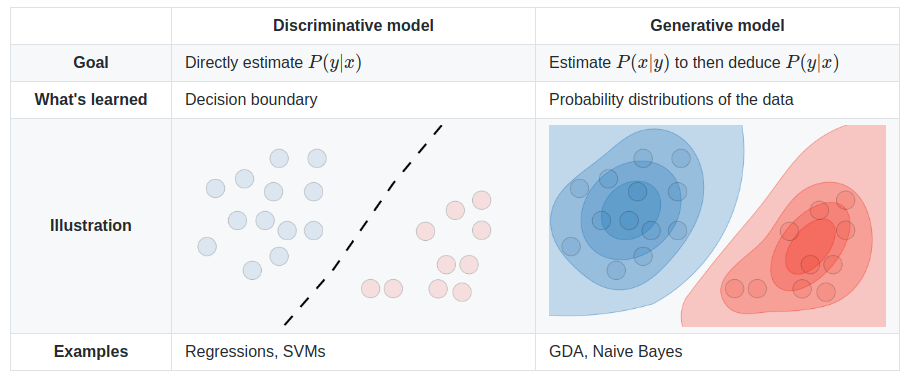

For classification:
- $P(C|X)$ is the goal:
- Select $c^*$ (specific class) with highest $P(C|X)$

Using the fancy maths:

$$ c^* = f(X) = \arg\max_{c} P(C = c| X)  $$

But we can also take advantage of Bayes Theorem:

 $$ c^* = f(X) = \arg\max_{c} \frac{P(X| C = c)P(C = c)}{P(X)} $$ 
 

 Simplifies as $P(X)$ doesn't depend on $C$:
 
 $$ c^* = f(X) = \arg\max_{c}  P(X| C = c)P(C = c)  $$ 

 $$ c^* = f(X) = \arg\max_{c} P(X| C = c)P(C = c)$$

**Now can use generative model for each class to help make prediction**
- How are features distributed within each class?
- Use this to help make prediction.

**Relative weights**:

Sex is male given pitch of voice.

$$ P(sex = M| pitch) \propto P(pitch|sex = M)P(sex = M)$$

Sex is female given pitch:

$$P(sex = F| pitch) \propto P(pitch|sex = F)P(sex = F)$$

Then choose winner.

<img src = "Images/generative_voice_pitch.jpg" />

- Use the separate distributions of features for male and female to aid us.

$$ P(C = c|X) \propto P(X| C = c)P(C = c) $$


- $P(C = c)$ is our prior estimate of class probabilities (before we factor in features)
    - literally, count labels in each class and calculate class fraction.
    - result of using DummyClassifier 

P(X) is just a constant (doesnt depend on class c). Thus:

 $$ c^* = f(X) = \arg\max_{c} P(X| C = c)P(C = c) $$
 
 is our Bayesian classifier.
 

$$ P(C = c|X) \propto P(X| C = c)P(C = c) $$
- $P(X| C = c)$ is the class-conditional distribution of features (likelihood function).
- **Get best parameters of distribution to fit training data**

Assuming Gaussians: fit $\mu_c$, $\sigma_c$ for each class $c$
<img src = "Images/generative_voice_pitch.jpg" />

Fitting parameters of the class distribution on training set: 
- factor in the features and how they are distributed within the different classes.
- Adding this new knowledge to enhance Dummy classifier

Bayes classifier thus based on posterior:
$$ P(C = c|X) \propto P(X| C = c)P(C = c) $$

after knowledge update on dummy classifier prior via fitting distributions.

Before jumping in to do this:
- Why would I use this approach?

#### Features for each class modeled by known distribution type

- mass distribution for different species of penguin:
    - might model with normal distributions
- count rates of various words in spam vs. non-spam emails.
    - might model with multinomial distributions
    - like binomial counts but more than 2 outcomes


In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
penguin_df = pd.read_csv('data/penguins.csv')
lab_enc = LabelEncoder()
penguin_df['Species'] = lab_enc.fit_transform(penguin_df['Species'])
penguin_reduced = penguin_df[penguin_df['Species'] != 1][['Body Mass (g)', 'Species']]
penguin_reduced

,Body Mass (g),Species
0,3750,0
1,3800,0
2,3250,0
3,3450,0
4,3650,0
...,...,...
337,4925,2
338,4850,2
339,5750,2
340,5200,2


In [4]:
penguin_reduced.head()

,Body Mass (g),Species
0,3750,0
1,3800,0
2,3250,0
3,3450,0
4,3650,0


In [5]:
targ_classes = penguin_reduced.Species.unique()
print(targ_classes)
penguin_reduced.Species.value_counts()

[0 2]


0    151
2    123
Name: Species, dtype: int64

In [6]:
lab_enc.inverse_transform(targ_classes)

array(['Adelie Penguin (Pygoscelis adeliae)',
       'Gentoo penguin (Pygoscelis papua)'], dtype=object)

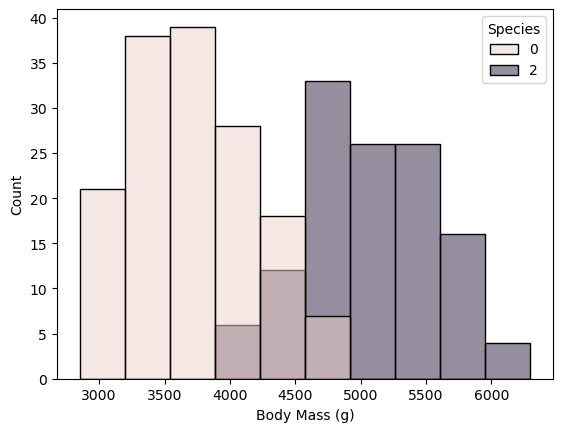

In [7]:
sns.histplot(x = 'Body Mass (g)', hue = 'Species', data = penguin_reduced)
plt.show()

EDA suggests that we *might* want to model the class conditional feature distribution:
- Mass for the different penguin species
- model as normal for each subpopulation

Could use Bayes' classifier here.

In [8]:
X = penguin_reduced['Body Mass (g)']
y = penguin_reduced['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
from sklearn.dummy import DummyClassifier
prior_est = DummyClassifier(strategy = 'prior')
prior_est.fit(X_train,y_train)

DummyClassifier()

In [10]:
prior = prior_est.predict_proba(X_test)[0]
prior_est.predict_proba(X_test)[0:2]

array([[0.55251142, 0.44748858],
       [0.55251142, 0.44748858]])

In [11]:
y_train.value_counts(normalize = True)

0    0.552511
2    0.447489
Name: Species, dtype: float64

Now let's run a Bayes Gaussian classifier:
- will model the features for different subclasses with separate normal distributions
- fit separate means and variances for each class

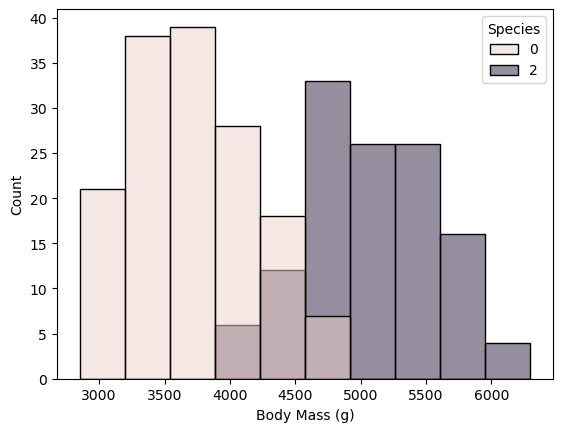

In [12]:
sns.histplot(x = 'Body Mass (g)', hue = 'Species', data = penguin_reduced)
plt.show()

Import the Gaussian Naive Bayes Classifier

In [13]:
from sklearn.naive_bayes import GaussianNB

In [14]:
gb_clf = GaussianNB()
gb_clf.fit(X_train.values.reshape(-1,1)
           , y_train)


GaussianNB()

Gaussian Naive Bayes stores:
- estimated means and variances for each target class. 
- Parameters for normal distributions modeling mass for each target class.

The means

In [15]:
# The means
gb_clf.theta_

array([[3687.39669421],
       [5055.35714286]])

In [16]:
train_df = pd.concat([X_train, y_train],
                     axis = 1)
man_mean = train_df.groupby('Species').mean()
man_mean

,Body Mass (g)
Species,
0,3687.396694
2,5055.357143


The variances

In [17]:
#gb_clf.sigma_
gb_clf.var_

array([[205373.1821665 ],
       [254046.55681227]])

In [18]:
man_var = train_df.groupby('Species').var(ddof = 0)
man_var

,Body Mass (g)
Species,
0,205373.181477
2,254046.556122


Taken the data and now have Gaussians for each class:
- mean extracted from data for each class
- variance extracted from data for each class.

Predict on the test set

In [19]:
X_test_nump = X_test.values.reshape(-1,1)
y_pred = gb_clf.predict(X_test_nump)

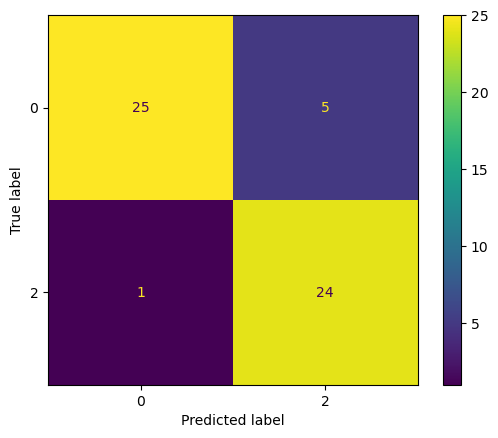

In [20]:
#plot_confusion_matrix(gb_clf, X_test_nump,y_test);
ConfusionMatrixDisplay.from_estimator(gb_clf, X_test_nump,y_test);

- Bayesian classifier: decent given the simplicity/size of the data and the features. 
- But how?
    - Get priors
    - Fits each class-conditional normal
    - Compute class posteriors

$$ P(C = c|X) = \frac{P(X| C = c)P(C = c)}{P(X)} $$

In [21]:
def manual_predict_proba(X, means, variances, priors):
    
    posterior_list = []
    
    for i in range(len(priors)):
        class_mean = means.iloc[i][0]
        class_std = np.sqrt(variances.iloc[i][0])
        
        # take fit means and stds to calculate data likelihood for the class
        # use normal distribution
        class_likelihood = norm.pdf(X, loc = class_mean, scale = class_std)
        
        # get the class prior
        prior = priors[i]
        
        # bayes theorem
        posterior_est = class_likelihood*prior
        posterior_list.append(posterior_est)
    
    return posterior_list/np.sum(posterior_list)

        

Get class posteriors for single data point:

In [22]:
penguin_mass = 2000

In [23]:
manual_predict_proba(penguin_mass,man_mean,
                     man_var, prior)

array([9.99992175e-01, 7.82516053e-06])

In [24]:
X_tp = np.array([penguin_mass])
gb_clf.predict_proba(X_tp.reshape(-1,1))

array([[9.99992175e-01, 7.82516074e-06]])

Which class does the Bayes classifier assign to?

The Bayes classifier can be extended to more feature dimensions:
- In more dimensions **Naive** Bayes makes assumption
- Input features not correlated.

$$ P(C = c|\textbf{X}) = \frac{P(\textbf{X}| C = c)P(C = c)}{P(\textbf{X})} $$

In 2D: $ \textbf{X} = (X_1, X_2) $.

Under Naive assumption:

$$ P(C = c|\textbf{X}) = \frac{P(X_1| C = c)P(X_2| C = c)P(C = c)}{P(\textbf{X})} $$

In [25]:
penguin_df_2D = penguin_df[['Culmen Length (mm)', 'Delta 15 N (o/oo)', 'Species']].rename(
    columns = {'Culmen Length (mm)': 'culmen_length', 'Species': 'species', 'Delta 15 N (o/oo)': 'N_isotope'}).dropna()

/Users/josephmata/opt/anaconda3/envs/dplearn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


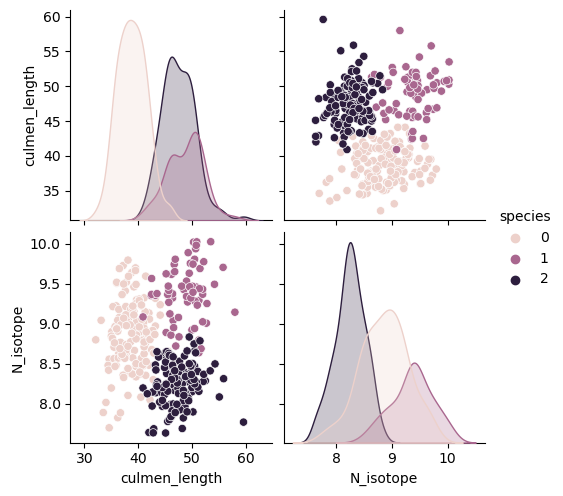

In [26]:
sns.pairplot(hue = 'species', 
             data = penguin_df_2D);

Not a lot of correlation between features within each group.

In [27]:
X_2D = penguin_df_2D.drop(columns = ['species'])
y_2D = penguin_df_2D['species']

In [28]:
penguin_df_2D.groupby('species').corr()

culmen_length  N_isotope
species                                        
0       culmen_length       1.000000   0.090125
        N_isotope           0.090125   1.000000
1       culmen_length       1.000000   0.168243
        N_isotope           0.168243   1.000000
2       culmen_length       1.000000   0.144730
        N_isotope           0.144730   1.000000

In [29]:
# train test split 
X_train_2D, X_test_2D, y_train_2D, y_test_2D = train_test_split(X_2D, y_2D, test_size = 0.3, random_state = 42)
clf_2d_gauss = GaussianNB()
clf_2d_gauss.fit(X_train_2D, y_train_2D)

GaussianNB()

Let's look at the test performance:

In [30]:
y_pred = clf_2d_gauss.predict(X_test_2D)

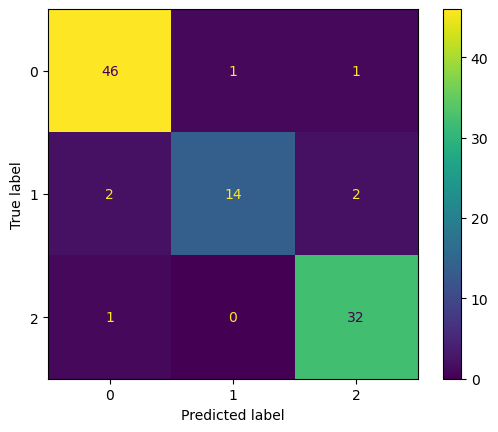

In [31]:
#plot_confusion_matrix(clf_2d_gauss, X_test_2D, y_test_2D);
ConfusionMatrixDisplay.from_estimator(clf_2d_gauss, X_test_2D, y_test_2D);

In [32]:
print(classification_report(y_pred, y_test_2D))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        49
           1       0.78      0.93      0.85        15
           2       0.97      0.91      0.94        35

    accuracy                           0.93        99
   macro avg       0.90      0.93      0.91        99
weighted avg       0.93      0.93      0.93        99



It's working quite well. Let's look at the decision boundaries:

/Users/josephmata/opt/anaconda3/envs/dplearn/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


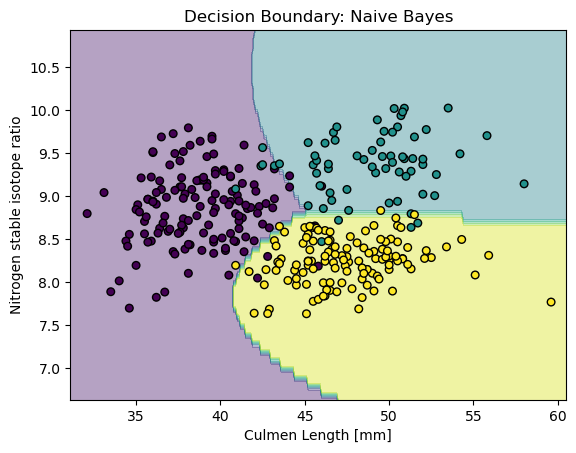

In [33]:
X_2Dn = X_2D.values
x_min, x_max = X_2Dn[:, 0].min() - 1, X_2Dn[:, 0].max() + 1
y_min, y_max = X_2Dn[:, 1].min() - 1, X_2Dn[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, ax = plt.subplots()

Z = clf_2d_gauss.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(X_2Dn[:, 0], X_2Dn[:, 1], c = y_2D, s=30, edgecolor="k")
ax.set_xlabel('Culmen Length [mm]')
ax.set_ylabel('Nitrogen stable isotope ratio')
ax.set_title('Decision Boundary: Naive Bayes')
plt.show()

Can learn quadratic decision surfaces easily. 

Now let' take a look at a different feature set:

In [34]:
reduced_pg_df = penguin_df[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Species']]

/Users/josephmata/opt/anaconda3/envs/dplearn/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


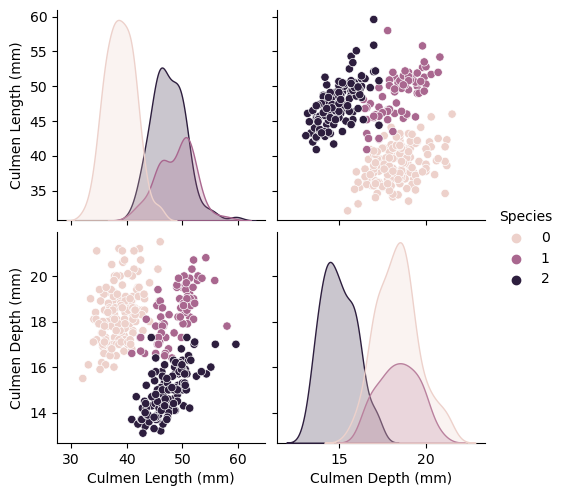

In [35]:
sns.pairplot(hue = 'Species',
             data = reduced_pg_df);

In [36]:
reduced_pg_df.groupby('Species').corr()

Culmen Length (mm)  Culmen Depth (mm)
Species                                                          
0       Culmen Length (mm)            1.000000           0.391492
        Culmen Depth (mm)             0.391492           1.000000
1       Culmen Length (mm)            1.000000           0.653536
        Culmen Depth (mm)             0.653536           1.000000
2       Culmen Length (mm)            1.000000           0.643384
        Culmen Depth (mm)             0.643384           1.000000

Culmen length and depth are clearly correlated:
- Naive Bayes probably won't be an optimal model.

In [37]:
X_2D_PG = reduced_pg_df.drop(columns = ['Species'])
y_2D_PG = reduced_pg_df['Species']
X_train_2D_PG, X_test_2D_PG, y_train_2D_PG, y_test_2D_PG = train_test_split(X_2D_PG, y_2D_PG,
                                                                            test_size = 0.4, random_state = 42)

#### Naive Bayes Results

In [38]:
clf_2d_gauss2 = GaussianNB()
clf_2d_gauss2.fit(X_train_2D_PG, y_train_2D_PG)
y_pred = clf_2d_gauss2.predict(X_test_2D_PG)

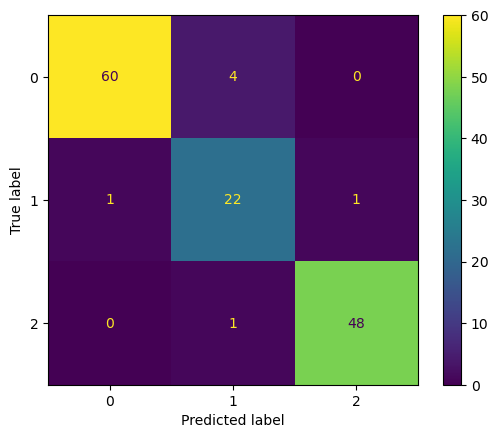

In [39]:
#plot_confusion_matrix(clf_2d_gauss2, X_test_2D_PG,y_test_2D_PG);
ConfusionMatrixDisplay.from_estimator(clf_2d_gauss2, X_test_2D_PG,y_test_2D_PG);

In [40]:
print(classification_report(y_test_2D_PG,
                     y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        64
           1       0.81      0.92      0.86        24
           2       0.98      0.98      0.98        49

    accuracy                           0.95       137
   macro avg       0.93      0.94      0.93       137
weighted avg       0.95      0.95      0.95       137



#### Quadratic Discriminant Analysis

$$ P(C = c|\textbf{X}) = \frac{P(\textbf{X}| C = c)P(C = c)}{P(\textbf{X})} $$

- Use the **full multivariate normal** for each class including correlations between features.

As opposed to Naive Bayes:
   
$$ P(C = c|\textbf{X}) = \frac{P(X_1| C = c)P(X_2| C = c)P(C = c)}{P(\textbf{X})} $$

In [41]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [42]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_2D_PG, y_train_2D_PG)
y_pred_qda = qda.predict(X_test_2D_PG)

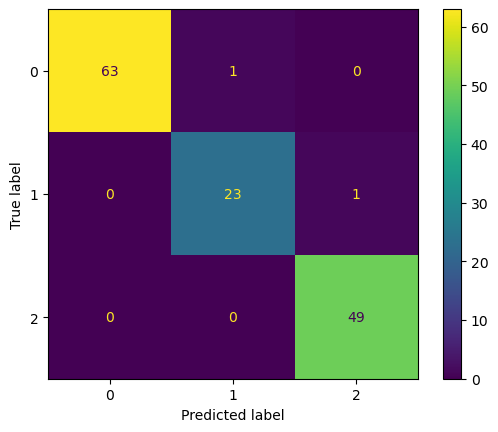

In [43]:
#plot_confusion_matrix(qda, X_test_2D_PG, y_test_2D_PG);
ConfusionMatrixDisplay.from_estimator(qda, X_test_2D_PG, y_test_2D_PG);

In [44]:
print(classification_report(y_test_2D_PG,y_pred_qda))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        64
           1       0.96      0.96      0.96        24
           2       0.98      1.00      0.99        49

    accuracy                           0.99       137
   macro avg       0.98      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137



Evaluating the different decision boundaries:

/Users/josephmata/opt/anaconda3/envs/dplearn/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


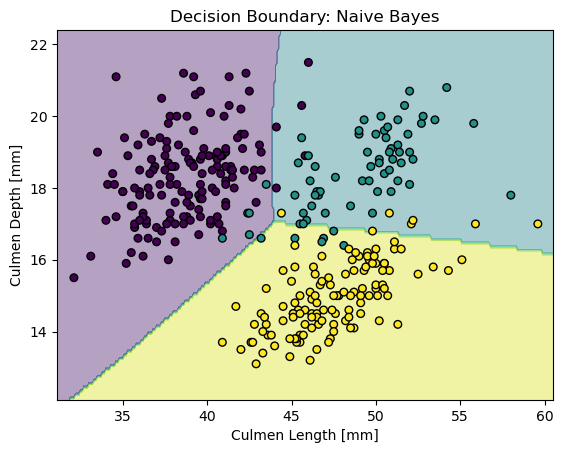

In [45]:
X_2Dn = X_2D_PG.values
x_min, x_max = X_2Dn[:, 0].min() - 1, X_2Dn[:, 0].max() + 1
y_min, y_max = X_2Dn[:, 1].min() - 1, X_2Dn[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, ax = plt.subplots()

Z = clf_2d_gauss2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(X_2Dn[:, 0], X_2Dn[:, 1], c = y_2D_PG, s=30, edgecolor="k")
ax.set_xlabel('Culmen Length [mm]')
ax.set_ylabel('Culmen Depth [mm]')
ax.set_title('Decision Boundary: Naive Bayes')
plt.show()

/Users/josephmata/opt/anaconda3/envs/dplearn/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


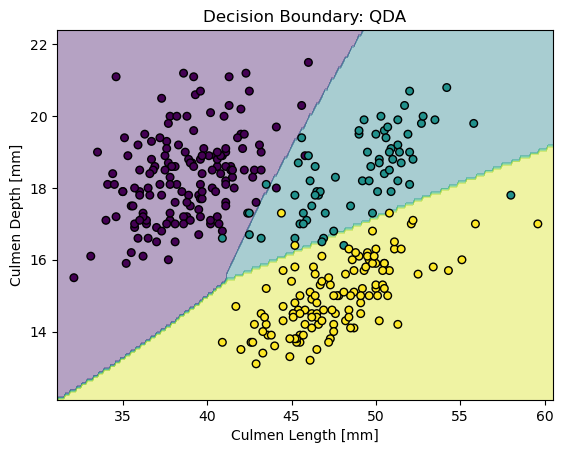

In [46]:
X_2Dn = X_2D_PG.values
x_min, x_max = X_2Dn[:, 0].min() - 1, X_2Dn[:, 0].max() + 1
y_min, y_max = X_2Dn[:, 1].min() - 1, X_2Dn[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, ax = plt.subplots()

Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(X_2Dn[:, 0], X_2Dn[:, 1], c = y_2D_PG, s=30, edgecolor="k")
ax.set_xlabel('Culmen Length [mm]')
ax.set_ylabel('Culmen Depth [mm]')
ax.set_title('Decision Boundary: QDA')
plt.show()

#### Bayesian based classifiers

- Modeling the features partitioned by class by fitting
- Downside: have to assume a reasonable distribution
    - i.e. learning parameters of simpler functions
    - less flexible than tree based methods

- Upside: 
    - Can work better than other methods when dataset is small
    - Can use for inference
    - Don't have to scale.

**Naturally allows you to update probabilities for sequential learning**
- previous posterior becomes input prior
- take in new data
- get new probabilities.


#### Will see other distributions in the Bayesian classifier framework later
- MultinomialNB when doing classification in Natural language processing context.